In [ ]:
import sys
sys.path.append("/scratch/group/csce-435-f25/python-3.10.8/lib/python3.10/site-packages")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

: 

Read all files

In [2]:
#runs is a name of a folder containing the cali files, you may create a folder with a different name and replace the folder name here
paths = glob("third_try/*.cali") + glob("sample_cali_regen/*.cali") + glob("merge_calis/*.cali")
tk = th.Thicket.from_caliperreader(paths)


(2/2) Creating Thicket: 100%|██████████| 839/839 [00:21<00:00, 38.64it/s]


View Calltree

In [83]:
print(tk.tree(metric_column="Avg time/rank"))

  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2025.1.0

7.631 main
├─ 1.754 MPI_Init
└─ 5.764 main
   ├─ 0.000 _data_init_runtime_
   ├─ 3.255 comm
   │  └─ 3.255 comm_large
   │     ├─ 3.241 MPI_Scatterv
   │     └─ 0.014 MPI_Gatherv
   ├─ 2.508 radix_sort
   │  ├─ 2.021 comm
   │  │  ├─ 1.577 comm_small
   │  │  │  └─ 1.553 MPI_Allreduce
   │  │  └─ 0.443 comm_large
   │  │     ├─ 0.079 MPI_Alltoall
   │  │     └─ 0.365 MPI_Alltoallv
   │  └─ 0.478 comp
   │     ├─ 0.167 comp_small
   │     │  └─ 0.149 comm
   │     │     └─ 0.149 comm_small
   │     │        └─ 0.148 MPI_Exscan
   │     └─ 0.311 comp_large
   └─ 0.000 correctness_check

Legend (Metric: Avg time/rank Min: 0.00 Max: 7.63 indices: {'profile': np.int64(13529558703)})
█ 6.87 - 7.63
█ 5.34 - 6.87
█ 3.82 - 5.34
█ 2.29 - 3.82
█ 0.76 - 2.29
█ 0.00 - 0.76

name User code    ◀  Only in left graph  

Group Performance data by `matrix_size` in the Thicket metadata table.

In [3]:
md = tk.metadata.reset_index()[["profile", "num_procs", "input_type", "input_size", "algorithm"]]

tk.dataframe = tk.dataframe.reset_index().merge(md, on="profile", how="left").set_index(["num_procs", "input_size", "algorithm", "input_type"]).sort_index()

In [4]:
tk.dataframe.columns

Index(['node', 'profile', 'nid', 'spot.channel', 'Min time/rank',
       'Max time/rank', 'Avg time/rank', 'Total time', 'Calls/rank (min)',
       'Calls/rank (avg)', 'Calls/rank (max)', 'Calls (total)',
       'Min time/rank (exc)', 'Max time/rank (exc)', 'Avg time/rank (exc)',
       'Total time (exc)', 'name'],
      dtype='object')

In [5]:
# Change font size for all plots
plt.rcParams.update({"font.size": 20})
df = tk.dataframe.reset_index()

# df.groupby(["input_type", "name"]).size()

In [8]:
import numpy as np
def plot_strong_speedup(df, input_size, metric, input_type):
    processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    algorithms = ["Radix Sort", "merge", "SampleSort"]
    time_col = "Avg time/rank"
    types = {
        0: "Sorted",
        1: "1% Perturbed",
        2: "Random",
        3: "Reverse Sorted"
    }
    
    
    sub = df[(df["input_type"] == input_type) & (df["input_size"] == input_size) & (df["name"] == metric) ].copy()

    g = (sub.groupby(["algorithm", "num_procs"], as_index=False)[time_col].mean())

    plt.figure(figsize=(10, 7))
    p0 = 2

    for algorithm in algorithms:
        ga = g[g["algorithm"] == algorithm].set_index("num_procs")[time_col].reindex(processes)
        base = ga.loc[p0]
        speedup = base / ga
        plt.plot(speedup.index, speedup.values, marker="o", label=algorithm)

    ideal = [p/p0 for p in processes]
    plt.plot(processes, ideal, linestyle="--", color="black", label="Ideal Speedup")

    it_label = types.get(input_type, str(input_type))
    plt.xlabel("Number of Processes")
    plt.ylabel("Speedup (T@2 / T@p)")
    plt.title(f"{metric} Strong Scaling Speedup for ")
    plt.xscale("log", base=2)
    plt.xticks(processes, processes)
    plt.yscale("log", base = 2)
    max_speedup = max(ideal + [1])  # upper bound for ticks
    y_ticks = [2**i for i in range(int(np.log2(max_speedup)) + 2)]
    plt.yticks(y_ticks, y_ticks)
    
    plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show() 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_weak_scaling(df, metric):
    weak_scaling_map = {
        2: 2**16, 4: 2**18, 8: 2**20, 16: 2**22,
        32: 2**24, 64: 2**26, 128: 2**28,
        256: 2**28, 512: 2**28, 1024: 2**28
    }
    processes = list(weak_scaling_map.keys())
    algorithms = ["Radix Sort", "merge", "SampleSort"]
    time_col = "Avg time/rank"
    type_labels = {
        0: "Sorted",
        1: "1% Perturbed",
        2: "Random",
        3: "Reverse Sorted"
    }

    sub = df[df["name"] == metric].copy()

    fig, axes = plt.subplots(2, 2, figsize=(14, 9), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, (type_id, type_label) in enumerate(type_labels.items()):
        ax = axes[i]
        for algorithm in algorithms:
            times = []
            for p in processes:
                size = weak_scaling_map[p]
                val = sub[
                    (sub["algorithm"] == algorithm)
                    & (sub["input_type"] == type_id)
                    & (sub["input_size"] == size)
                ][time_col].mean()
                times.append(val)
            ax.plot(processes, times, marker="o", label=algorithm)

        ax.set_xscale('log', base=2)
        ax.set_xticks(processes)
        ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
        ax.set_title(type_label)
        ax.set_xlabel("Number of Processes")
        ax.set_ylabel("Avg Time / Rank")
        ax.grid(True, alpha=0.3)
        ax.legend()

    fig.suptitle(f"Weak Scaling: {metric}", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

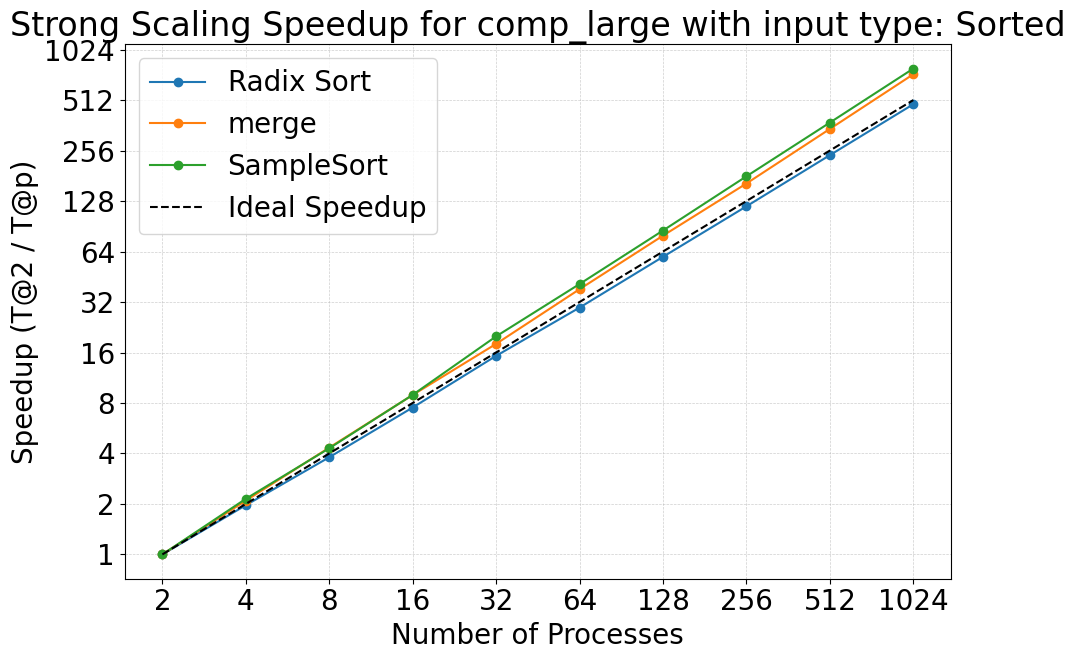

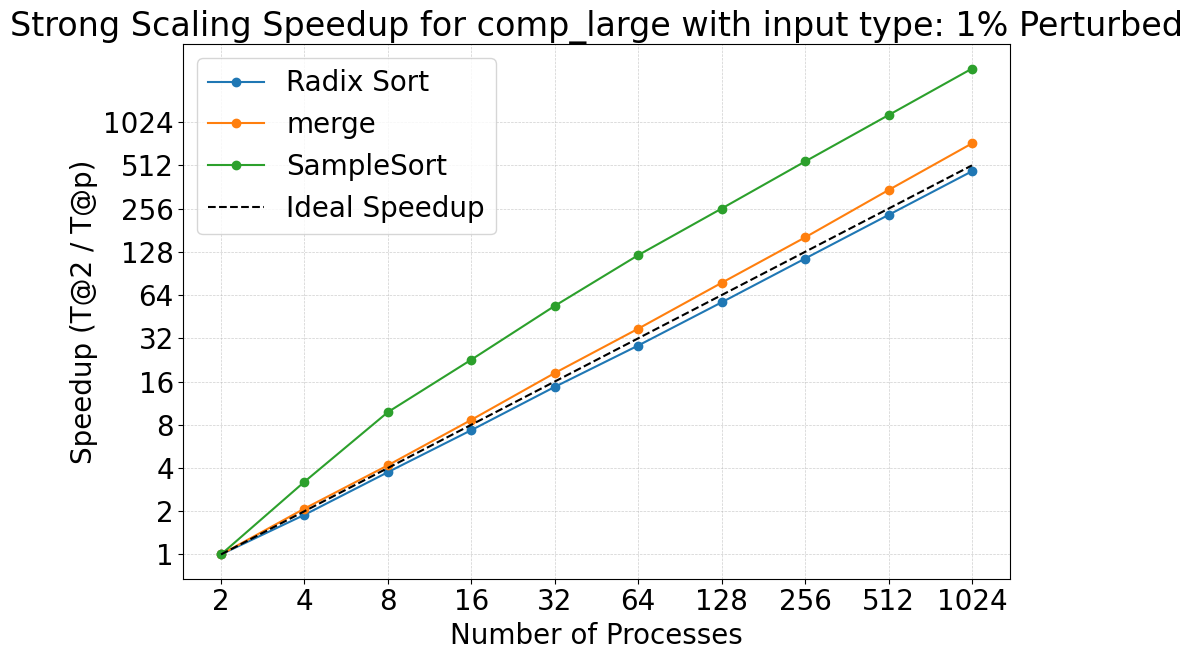

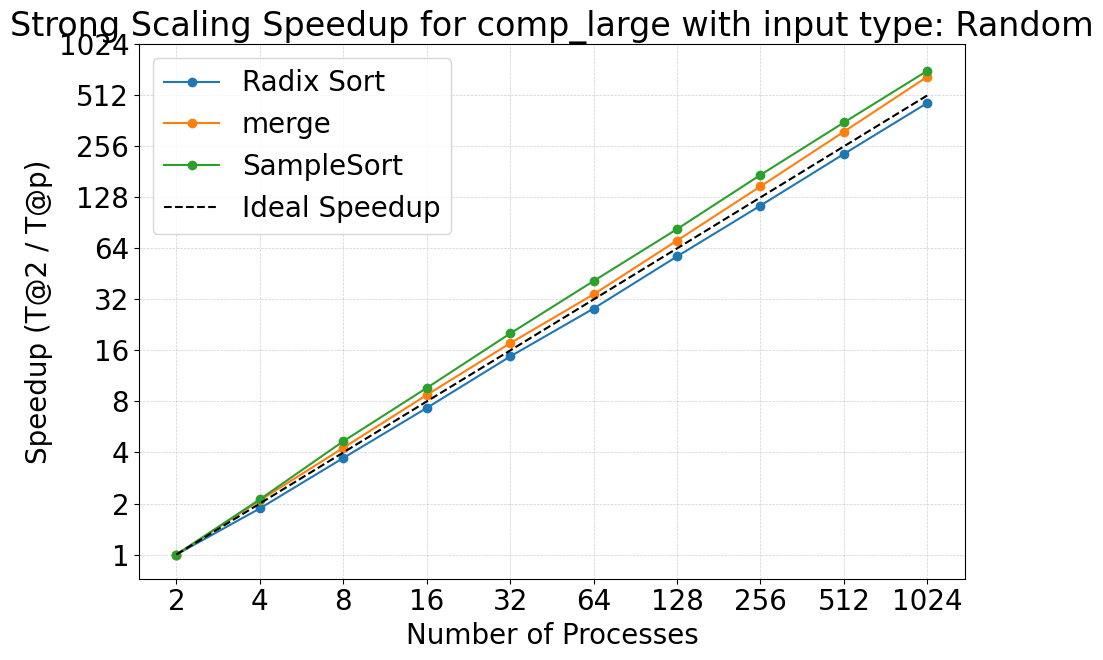

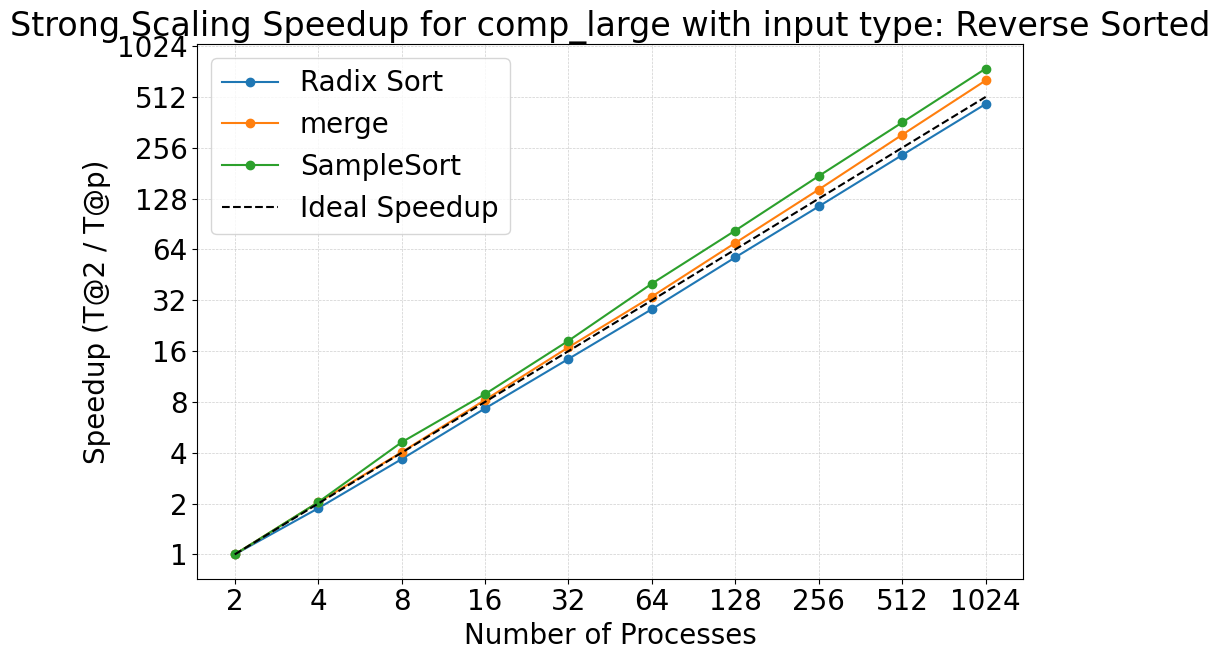

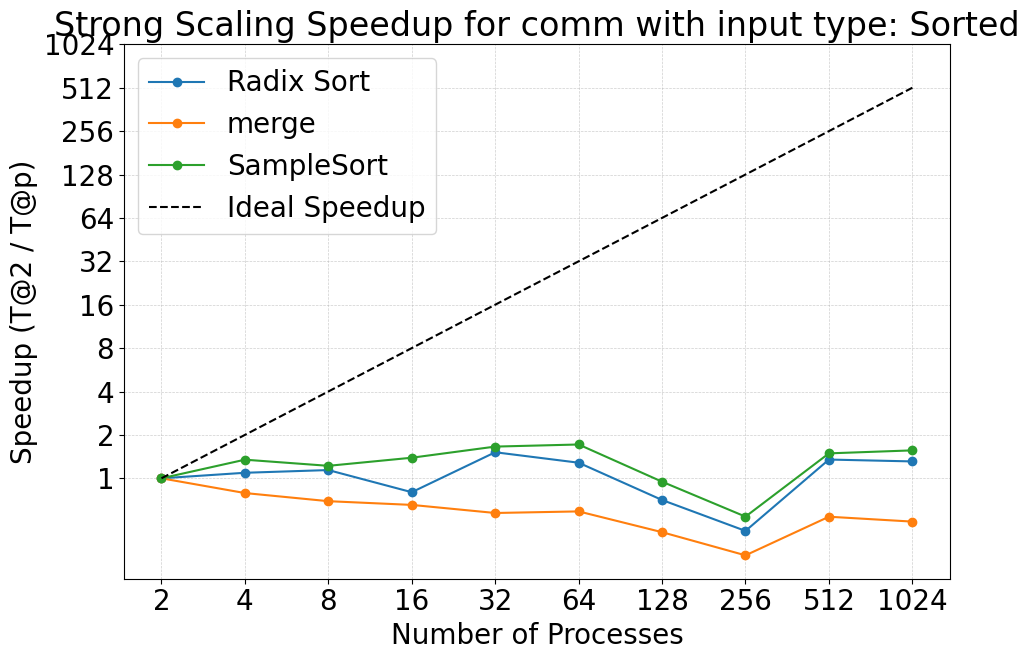

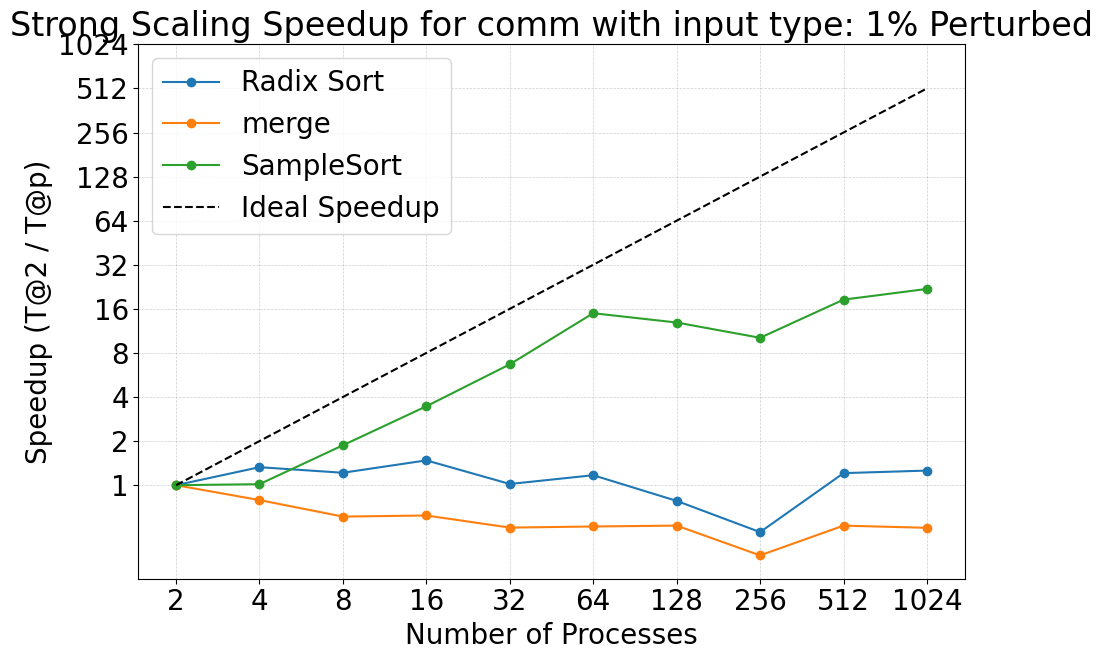

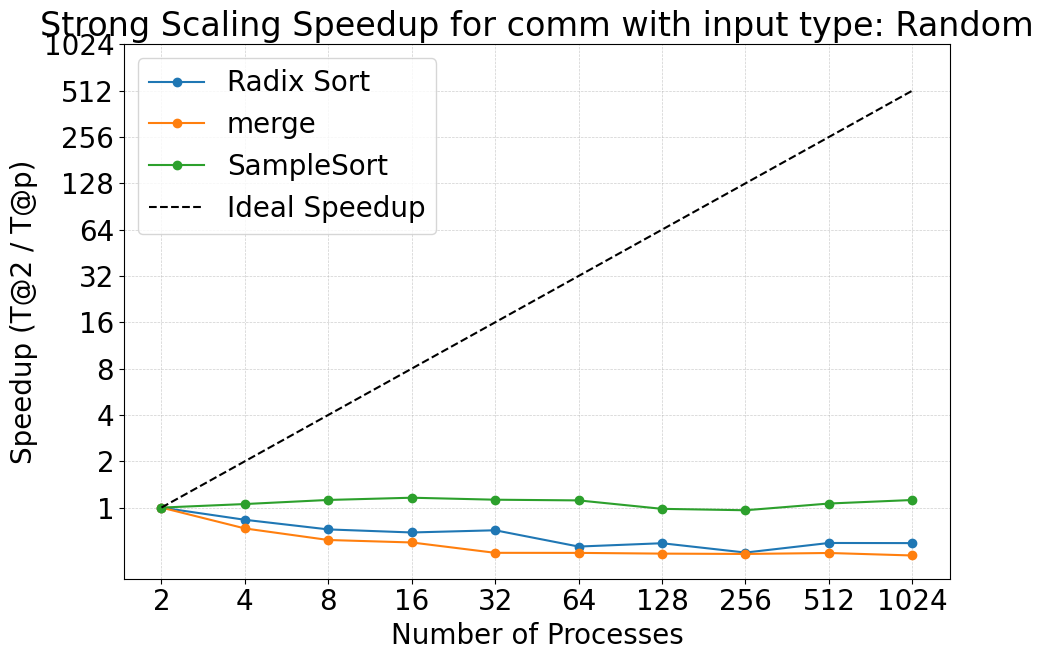

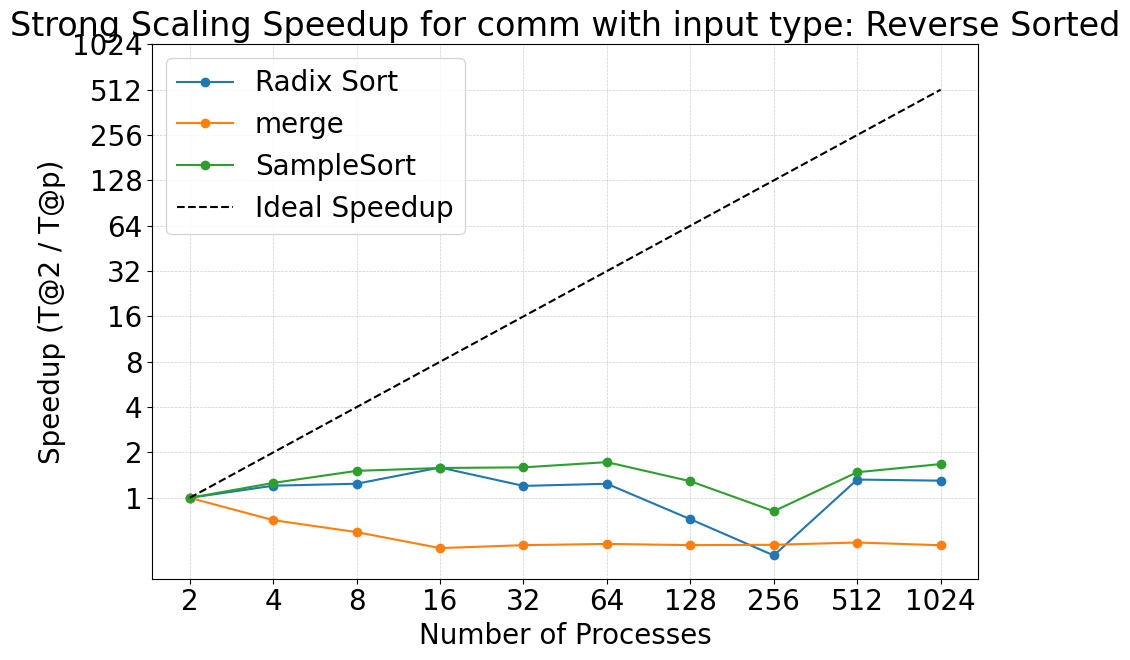

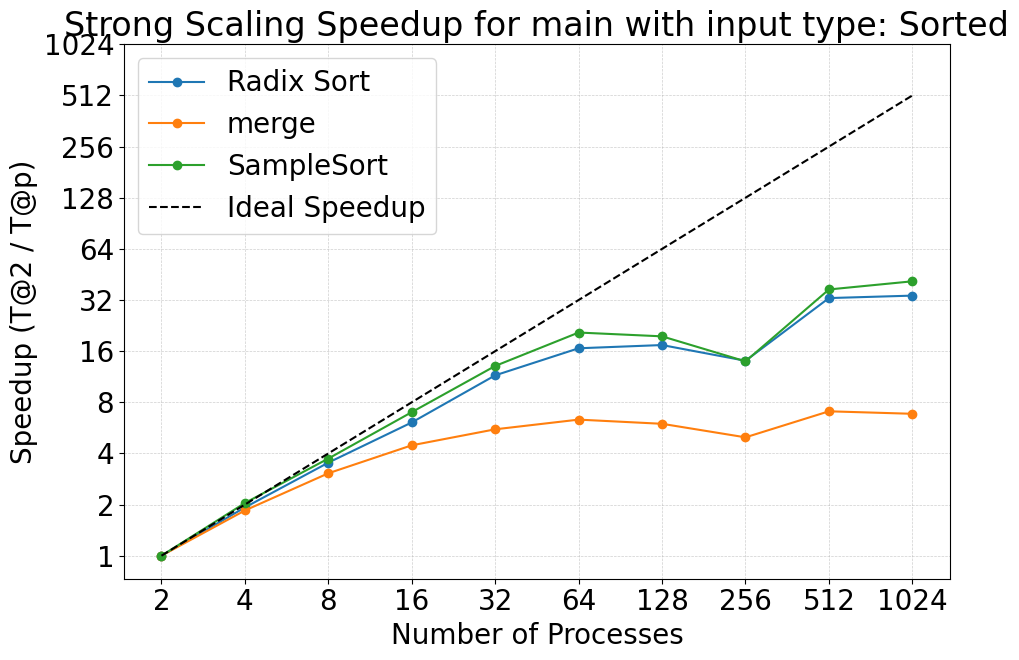

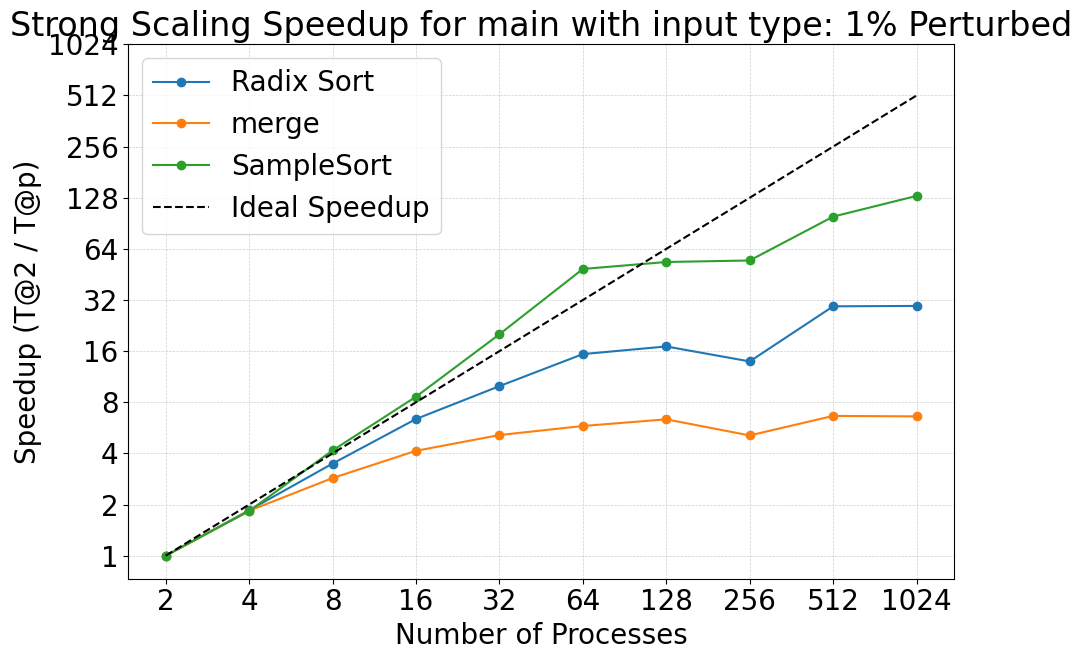

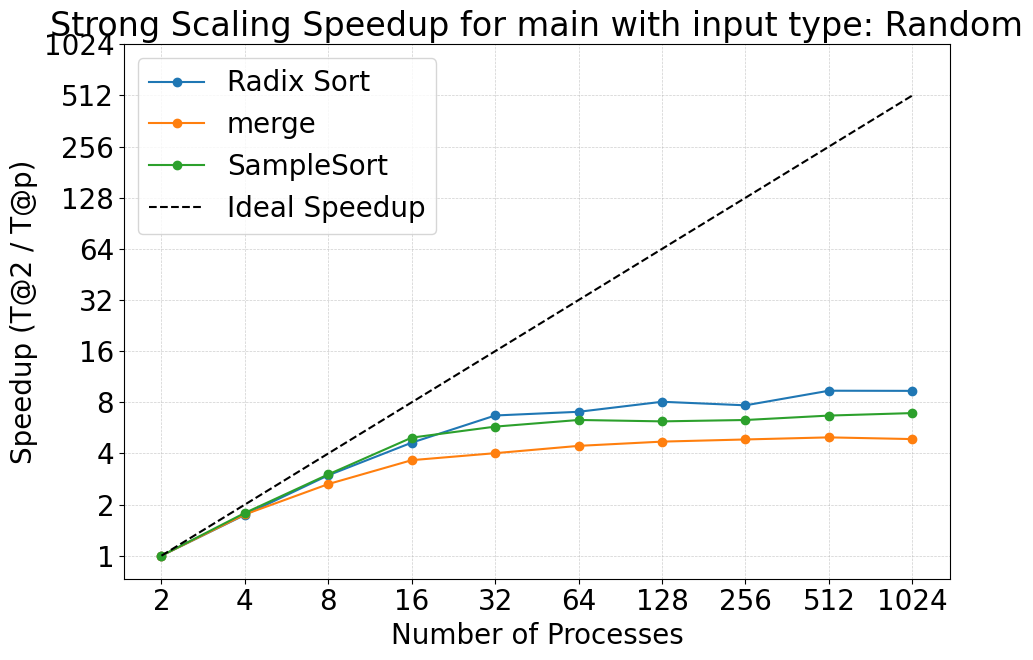

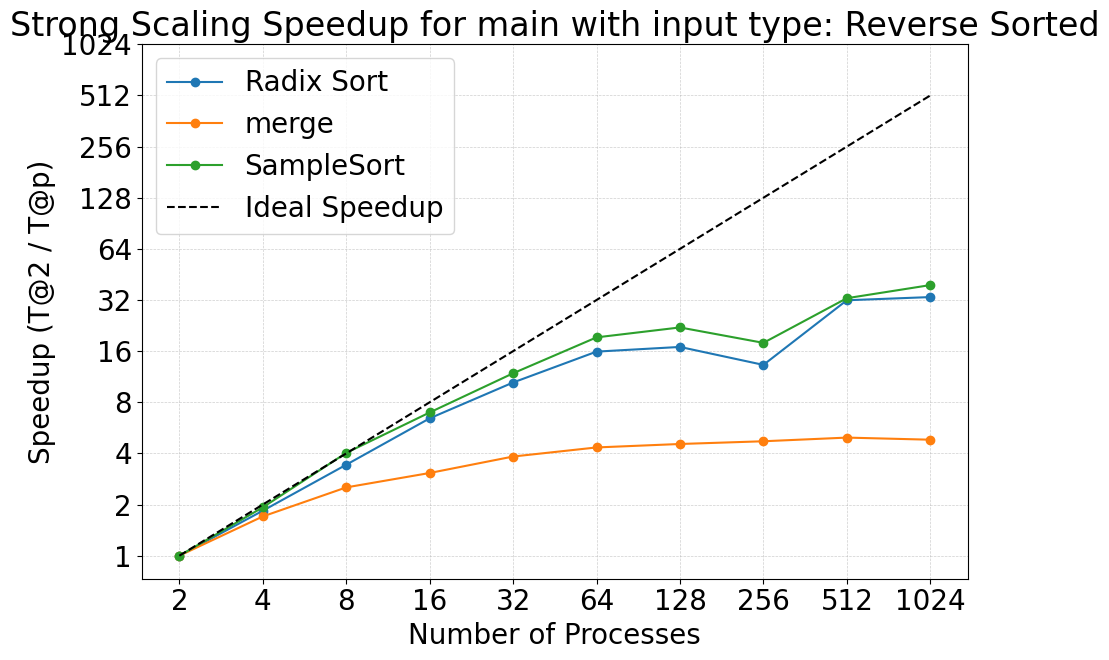

In [ ]:
fixed_size = 2**28
metrics = ["comp_large", "comm", "main"]

for metric_name in metrics:
    plot_strong_speedup(df, fixed_size, metric_name)

for metric_name in metrics:
    plot_weak_scaling(df, metric_name)  